# Import packages

In [27]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import PIL

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

from sklearn.model_selection import train_test_split
import shutil
import os

from huggingface_hub import notebook_login
from diffusers import DiffusionPipeline
from transformers import TrainingArguments, Trainer

# Load data

### Labels and descriptions of spectrograms

In [2]:
mono = pd.read_csv('description/mono.csv')
stereo = pd.read_csv('description/mono.csv')

In [3]:
mono.head()

,text
0,The low quality recording features a ballad so...
1,The low quality recording features a ballad so...
2,The low quality recording features a ballad so...
3,The low quality recording features a ballad so...
4,This song features an electric guitar as the m...


### Load images

In [18]:
# Set the directory path of the original dataset
data_dir = '../hugging_face_images/stereo'

# Set the directory path for the new training set and testing set
train_dir = './data/train'
test_dir = './data/test'

# Create the train and test directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)


In [19]:
# Split the dataset into train and test sets
images = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

In [20]:
#  Copy the training images to the train directory
for img in train_images:
    label = img.split('_')[0]
    if not os.path.exists(os.path.join(train_dir, label)):
        os.makedirs(os.path.join(train_dir, label))
    shutil.copy(os.path.join(data_dir, img), os.path.join(train_dir, label, img))

# Copy the testing images to the test directory
for img in test_images:
    label = img.split('_')[0]
    if not os.path.exists(os.path.join(test_dir, label)):
        os.makedirs(os.path.join(test_dir, label))
    shutil.copy(os.path.join(data_dir, img), os.path.join(test_dir, label, img))


In [15]:
# Define the transformations to apply to the images
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # resize the image to 224x224
    transforms.ToTensor(),           # convert the image to a PyTorch tensor
    transforms.Normalize(            # normalize the image pixel values
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [22]:
# Define the dataset using the ImageFolder class
dataset = ImageFolder('data', transform=data_transforms)

In [23]:
# Define the data loader to load data from the dataset
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [24]:
# load training and testing data
train_data = ImageFolder(train_dir, transform=data_transforms)
test_data = ImageFolder(test_dir, transform=data_transforms)

# Load Hugging Face model

In [6]:
notebook_login()

In [9]:
pipeline = DiffusionPipeline.from_pretrained("riffusion/riffusion-model-v1")

2023-05-03 18:31:27.055517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/Library/Python/3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/Library/Python/3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:165: FutureWarning: The configuration file of the unet has set the default `sample_size` to smaller than 64 which seems highly unlikely. If your checkpoint is a fine-tuned version of any of the following: 


In [12]:
pipeline

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [32]:
prompt = "jazz music"
image = pipeline(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

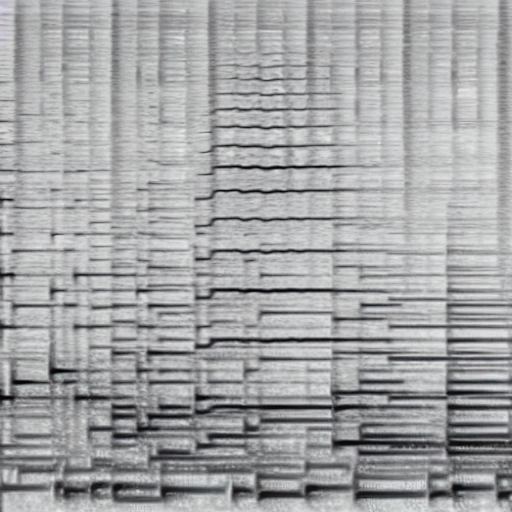

In [33]:
image

In [34]:
# save image
image.save("jazz_music.jpg")

In [36]:
prompt1 = "rap music with dentist sound in the background"
image1 = pipeline(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

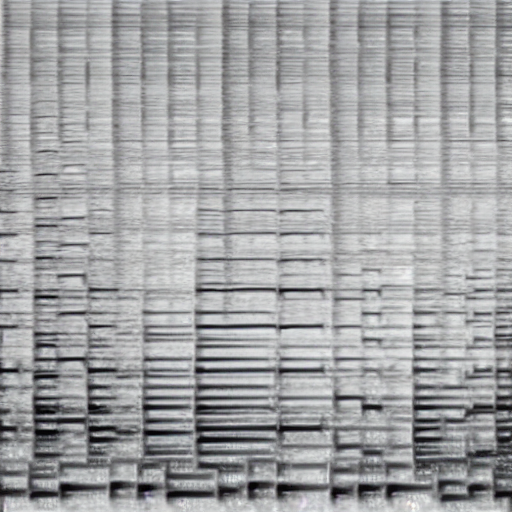

In [37]:
image1

In [38]:
# save image
image1.save("rap.jpg")

In [35]:
from diffusion.training_utils import Trainer

ModuleNotFoundError: No module named 'diffusion.training_utils'

In [ ]:
# finetune the model
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=pipeline,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_data,            # training dataset
    eval_dataset=test_data               # evaluation dataset
)

trainer.train()

trainer.evaluate()


In [13]:
# Set up the training configuration
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,             # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [29]:
trainer = Trainer(
    model=pipeline,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)

In [30]:
trainer.train()

AttributeError: 'StableDiffusionPipeline' object has no attribute 'forward'

In [31]:
pipeline.run(train_data, num_steps=1000, eval_steps=100)

AttributeError: 'StableDiffusionPipeline' object has no attribute 'run'

In [25]:
# Train the model on your data
trainer = pipeline.get_trainer(training_args=training_args)
trainer.train(train_data)

AttributeError: 'StableDiffusionPipeline' object has no attribute 'get_trainer'